# Prediction Metrics for MATCH

Created by Eric Kong on 21 June 2021.
Last modified by Eric Kong on 15 July 2021.

For PeTaL Labeller Issue #42 (https://github.com/nasa-petal/PeTaL-labeller/issues/42), a start to analyzing precision, recall, &c., of MATCH.

Also relevant to Issue #55 (https://github.com/nasa-petal/PeTaL-labeller/issues/55).

In [ ]:
!pip3 install gdown

In [4]:
import os
import gdown

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from collections import namedtuple
from tqdm import tqdm

In [ ]:
if not os.path.exists('MATCH/'):
    url = "https://drive.google.com/uc?id=1Ly--Y2w9ZQWZ_v9Kb6o742DTWokR7Rbi" # MATCH_20210716
    # url = "https://drive.google.com/uc?id=1iUwxS7HsP-T9kBkPR3ZMn_bGnn80ydTv" # MATCH_20210714
    output = "MATCH.tar.gz"
    gdown.download(url, output, quiet=False)

    !tar -xvf MATCH.tar.gz
else:
    print("You have already downloaded our modified MATCH repository.")

In [ ]:
%cd ./MATCH
!ls

In [ ]:
# Install requirements in requirements.txt
!chmod 755 -R .
!pip3 install -r requirements.txt

In [8]:
DATASET = "PeTaL"
MODEL = "MATCH"

## Calculation of precision and recall

In [ ]:
res_labels = np.load(f"{DATASET}/results/{MODEL}-{DATASET}-labels.npy")
res_scores = np.load(f"{DATASET}/results/{MODEL}-{DATASET}-scores.npy")
test_labels = np.load(f"{DATASET}/test_labels.npy")

In [ ]:
Stats = namedtuple("Stats", "threshold topk precision recall f1")

"""
    compute_stats(threshold)

    Parameters:
        threshold: float, 0.0 < threshold < 1.0
        res_labels: numpy array of predicted labels
        res_scores: numpy array of predicted label scores
        test_labels: numpy array of target labels
    
    Returns:
        Stats object containing
            threshold
            topk: average number of labels above threshold
            precision: average precision across examples
            recall: average recall across examples
            f1: average F1 score across examples
    
    Note:
        precision, recall, and F1 scores are macro (averaged across examples, not labels)
"""
def compute_stats(threshold, res_labels, res_scores, test_labels):
    precisions = []
    recalls = []
    topks = []
    f1s = []
    for res_label, res_score, test_label in zip(res_labels, res_scores, test_labels):
        topk = np.argmax(res_score < threshold) # topk becomes the number of labels scoring above the threshold
        precision = 1.0 if topk == 0 else np.mean([1 if x in test_label else 0 for x in res_label[:topk]])
        recall = np.mean([1 if x in res_label[:topk] else 0 for x in test_label])
        f1 = 0 if (precision + recall) == 0 else (2 * precision * recall) / (precision + recall)
        topks.append(topk)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        # print(res_label[:topk], precision, recall)
    return Stats(threshold, np.mean(topks), np.mean(precisions), np.mean(recalls), np.mean(f1s))
    # print("Threshold:", threshold)
    # print("Average number of labels:", np.mean(topks))
    # print("Average precision:", np.mean(precisions))
    # print("Average recall:", np.mean(recalls))
    # print("Average F1 score:", np.mean(f1s))

In [ ]:
thresholds = list(x / 1000 for x in range(1, 10)) + \
    list(x / 100 for x in range(1, 10)) + \
    list(x / 20 for x in range(2, 19)) + \
    list((90 + x) / 100 for x in range(1, 10)) + \
    list((990 + x) / 1000 for x in range(1, 10))

ps = []
rs = []
ts = []
f1s = []
topks = []
for threshold in tqdm(thresholds):
    stats = compute_stats(threshold, res_labels, res_scores, test_labels)
    ps.append(stats.precision)
    rs.append(stats.recall)
    ts.append(threshold)
    f1s.append(stats.f1)
    topks.append(stats.topk)

100%|██████████| 53/53 [00:00<00:00, 104.86it/s]


## Make plots

In this section we make the following plots to assess the performance of the model.

- Precision-recall curve
- Precision, recall, and F1 Score by varying threshold
- Number of labels predicted by varying threshold

(0.0, 1.0)

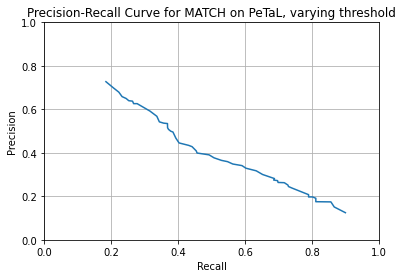

In [ ]:
plt.plot(ps, rs, linestyle='-')
plt.grid()
plt.title(f'Precision-Recall Curve for {MODEL} on {DATASET}, varying threshold')
plt.xlabel('Recall')
plt.xlim(0, 1)
plt.ylabel('Precision')
plt.ylim(0, 1)

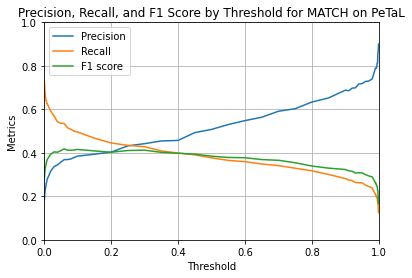

In [ ]:
plt.grid()
plt.title(f'Precision, Recall, and F1 Score by Threshold for {MODEL} on {DATASET}')
plt.plot(ts, ps, linestyle='-', label='Precision')
plt.plot(ts, rs, linestyle='-', label='Recall')
plt.plot(ts, f1s, linestyle='-', label='F1 score')
plt.xlabel('Threshold')
plt.xlim(0, 1)
plt.ylabel('Metrics')
plt.ylim(0, 1)
plt.legend()

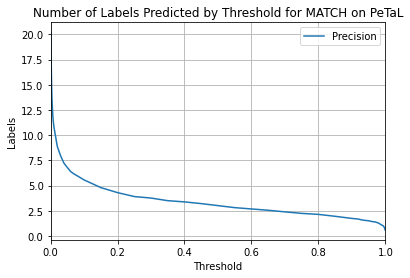

In [ ]:
plt.grid()
plt.title(f'Number of Labels Predicted by Threshold for {MODEL} on {DATASET}')
plt.plot(ts, topks, linestyle='-', label='Precision')
plt.xlabel('Threshold')
plt.xlim(0, 1)
plt.ylabel('Labels')
plt.legend()